<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/storgae/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sklearn
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=48b0795144ee65c94e4789692b84c8a0d11dbec98d16969e8d59bdb316694d14
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=601404532ac331f878fb48821d08bead43895e992692ac5613ac5bbb521286bb
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import pywt
from scipy import signal
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:

def lowpass_filter(data, cutoff, order):
  nyq = 0.5 * data.shape[-1]
  b, a = signal.butter(order, cutoff/nyq, 'lowpass')
  zi = signal.lfilter_zi(b, a)
  y, _ = signal.lfilter(b, a, data, zi=zi*data[0])
  return y


def lowpass(data, fs, fc, order):
    # Define the filter parameters
    b, a = signal.butter(order, fc / (fs / 2), 'lowpass')
    # Apply the filter to the data
    y = signal.filtfilt(b, a, data)
    return y

def SamplesToFreq(x,sample_rate):
  frequency = sample_rate / x
  return frequency

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='cmor', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

/usr/local/lib/python3.10/dist-packages/pywt/_utils.py:15: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.10/dist-packages/pywt/_utils.py:15: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.10/dist-packages/pywt/_utils.py:15: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the ba

(1.54, 1.6)

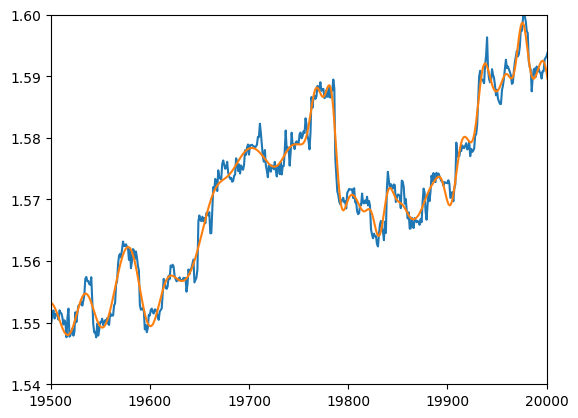

In [30]:

data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
data.dropna()
close = data.pop('BC')

data.pop('Date')
data.pop('Time')
data = (data-data.min())/(data.max()-data.min())

for wav in pywt.wavelist():
    try:
        filtered = wavelet_denoising(close, wavelet=wav, level=2)
    except:
        pass
    

#target = close.shift(+1).ffill()
#target = target.fillna(.5)
#target = np.diff(target,prepend=True,)
#target = (target-target.min())/(target.max()-target.min())


target = lowpass(close,len(close),10,2)
target = np.subtract(target,close)



plt.plot(close)
plt.plot(filtered)
#print(data)
plt.xlim(19500,20000)
plt.ylim(1.54,1.6)

In [4]:
from keras.regularizers import Regularizer
reg = tf.keras.regularizers.L2(l2=0.01)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, activation='gelu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation='gelu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='gelu',kernel_regularizer=reg),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
loss_fn = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['RootMeanSquaredError'])

In [5]:


hist = model.fit(data, target, epochs=10, batch_size=32)

Epoch 1/10
2909/2909 [==============================] - 24s 6ms/step - loss: 0.0492 - root_mean_squared_error: 0.0404
Epoch 2/10
2909/2909 [==============================] - 11s 4ms/step - loss: 0.0228 - root_mean_squared_error: 0.0311
Epoch 3/10
2909/2909 [==============================] - 6s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.0311
Epoch 4/10
2909/2909 [==============================] - 6s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.0311
Epoch 5/10
2909/2909 [==============================] - 7s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.0311
Epoch 6/10
2909/2909 [==============================] - 7s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.0311
Epoch 7/10
2909/2909 [==============================] - 9s 3ms/step - loss: 0.0227 - root_mean_squared_error: 0.0311
Epoch 8/10
2909/2909 [==============================] - 6s 2ms/step - loss: 0.0227 - root_mean_squared_error: 0.0311
Epoch 9/10
2909/2909 [==============================] - 8s 3ms

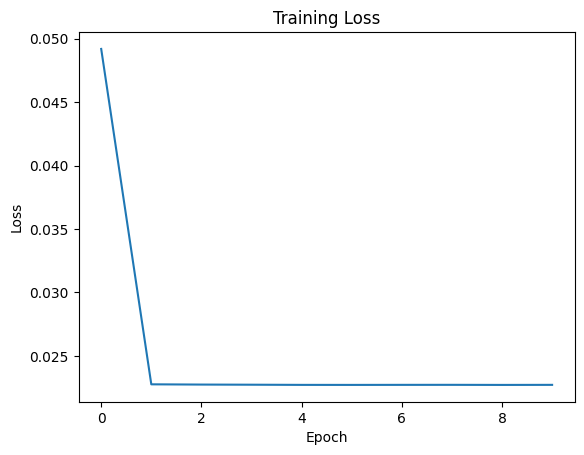

In [6]:
# Plot the training loss
plt.plot(hist.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
prediction = model.predict(data)

2909/2909 [==============================] - 4s 1ms/step


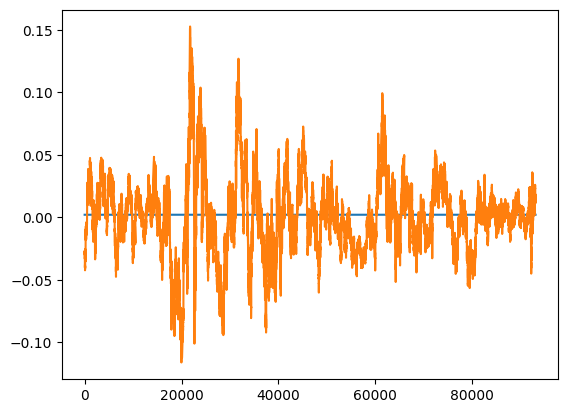

In [8]:
plt.plot(prediction)
plt.plot(target)